In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from datetime import datetime, timedelta

import pmdarima as pm

# Analiza danych rzeczywistych przy pomocy modelu ARMA

## 1. Wstęp 
Celem pracy jest analiza zbioru danych zawierającego dzienne pomiary średniej temperatury powietrza na stacji meteorologicznej w Warszawie w latach 1993 - 2022. Próba (po przygotowaniu danych do analizy) zawiera 10957 rekordów. 
Dane pochodzą z National Centers for Environmental Information. 

### 1.1.Przygotowanie danych do analizy 
Zbadano jakość danych - dokonano detekcji wartości spoza zakładanego przedziału, sprawdzono, czy nie występują braki w danych. 

Jak możemy zauważyć,  w próbie nie występują wartości odstające spoza zakładanego przedziału. Wśród danych dotyczących średniej tempereratury nie wystąpiły braki w danych 

In [22]:
date_format = '%Y-%m-%d'

df = pd.read_csv(r'..\data\warsaw.csv')
avg_temp = df['TAVG']
date = df['DATE']

# Informacje o brakach w danych
print(df.isnull().sum())
# Detekcja wartości spoza zakładanego przedziału (-30, 35)
print('Minimum z próby: ', min(avg_temp),'Maksimum z próby: ', max(avg_temp))


STATION         0
NAME            0
LATITUDE        0
LONGITUDE       0
ELEVATION       0
DATE            0
PRCP         1796
SNWD         9531
TAVG            0
TMAX         3491
TMIN         5084
dtype: int64
Minimum z próby:  -22.3 Maksimum z próby:  29.1


Sprawdzono również występowanie błędów w próbkowaniu. Wyznaczono trzy daty, dla których brakuje informacji o średniej dziennej temperaturze powietrza. W datach tych przypisano średnią wartość temperatury dnia poprzedniego i następnego. 

In [3]:
# Detekcja błędów w próbkowaniu, wyznaczenie wartości średniej temperatury 
date_int = []
date_date = []
avg_temp_copy = []

counter = 0

for i in range(len(date)):
    date_obj = datetime.strptime(date[i], date_format)
    date_date.append(date_obj)
    
    date_int_i = int(date_obj.strftime("%Y%m%d"))                  
    
    if i > 0:
        diff = date_int_i - date_int[-1]
        
        if diff == 2 or diff == 3:
            # print(date_int[-1], date_int_i)

            for j in range(1, diff):
                missing_date = date_date[i + counter - 1] + timedelta(days=j)
                date_date.append(missing_date)
                date_int.append(int(missing_date.strftime("%Y%m%d")))

                avg_temp_copy.append(round((avg_temp[i] + avg_temp[i - j])/2, 1))
            
            counter = counter + 1
            
    date_int.append(int(date_obj.strftime("%Y%m%d")))         
    avg_temp_copy.append(avg_temp[i])

date_date.sort()
date_int.sort()

avg_temp = avg_temp_copy

### 1.2. Wizualizacja trajektorii
Na wykresie poniżej przedstawiono wizualizację danych. Na tym etapie możemy zauważyć roczną sezonowość danych. Trend nie jest zauważalny, jednak uwzględniając zmiany środowiskowe, możemy spodziewać się rosnącej składowej trendu.

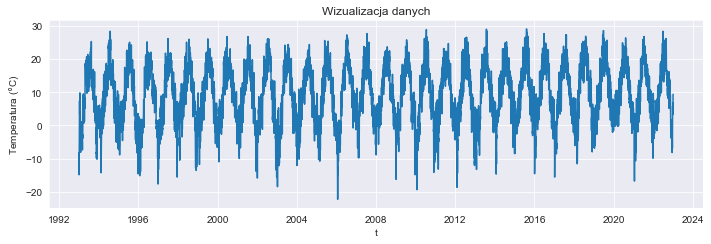

In [4]:
# Wizualizacja trajektorii

plt.figure(figsize=(10, 3.5))

plt.plot(date_date, avg_temp)
plt.xlabel('t')
plt.ylabel(r'Temperatura ($\degree$C)')
plt.title('Wizualizacja danych')

plt.tight_layout()
plt.show()

### 1.3. Wyodrębnienie z danych obserwacji do zbioru testowego
Z danych wyodrębnione zostały dane z ostatnich dwóch lat pomiarów (dwa okresy sezonowości). Wykorzystane zostaną do walidacji uzyskanego w dalszej części modelu.

In [5]:
date_date_all = date_date.copy()
avg_temp_all = avg_temp.copy()

In [6]:
date_date = date_date_all[0:10227]
date_date_test = date_date_all[10227:]

avg_temp = avg_temp_all[0:10227]
avg_temp_test = avg_temp_all[10227:]

## 2. Dekompozycja szeregu czasowego
Dokonamy dekompozycji badanego szeregu czasowego - wyznaczymy składową sezonową oraz trendu. 

### 2.1. Funkcje ACF i PACF dla surowych danych
Na wykresie autokorelacji (ACF) widoczna jest oscylacja wartości autokorelacji oraz bardzo powolne wygaszanie wraz ze wzrostem opóźnienia. Sugeruje to obecność składnika autoregresyjnego w danych. 
Na wykresie PACF widzimy znaczne odcięcie po opóźnieniu h = 3. Sugeruje to odpowiednią liczbę opóźnień dla modelu AR. 

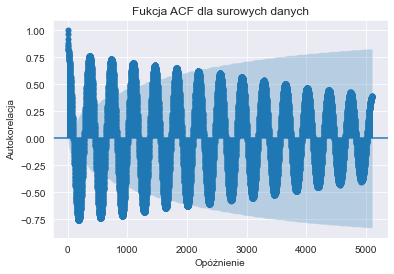

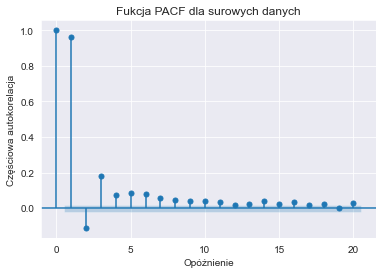

In [7]:
n = len(avg_temp)
lags = np.arange(0, n // 2)

plot_acf(avg_temp, lags=lags)                       # Wykres z użyciem funkcji bibliotecznej
plt.title('Fukcja ACF dla surowych danych')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.show()

plot_pacf(avg_temp, lags=20)
plt.title('Fukcja PACF dla surowych danych')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.show()

### 2.2. Weryfikacja hipotezy o niestacjonarności
Przeprowadzono test ADF do weryfikacji hipotezy o niestacjonarności dla surowych danych. p-wartość statystyki jest bliska 0.0, co daje podstawy do odrzucenia hipotezy o niestacjonarności. 

In [8]:
adf_test = adfuller(avg_temp)
print("ADF test p-value:", adf_test[1])

ADF test p-value: 1.5536538722253262e-08


### 2.3. Dekompozycja 
W dalszej części przejdziemy do dekompozycji szeregu czasowego przez wyznaczenie i usunięcie składowych trendu liniowego oraz funkcji okresowej.

Wykorzystane zostały różne metody dekompozycji, które zostały porównane na końcu podrozdziału. 

#### 2.3.1. Regresja liniowa oraz dopasowanie funkcji okresowej
Jako pierwszą sprawdzono metodę omawianą na ćwiczeniach. Metodą regresji liniowej dokonano predykcji trendu. Jako funkcję okresową, odpowiedzialną za sezonowość szeregu, przyjęto funkcję sinus. Parametry funkcji odczytano z wykresu trajektorii szeregu. 

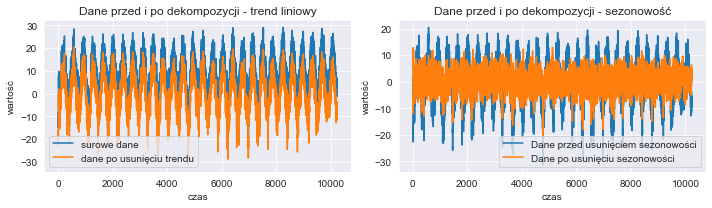

In [9]:
# Usuwanie trendu liniowego

time = np.arange(len(avg_temp))

linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), avg_temp)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))

avg_temp_without_linear_trend = avg_temp - trend_predicted

# Usuwanie funkcji okresowej

def sine_func(x, A, omega, phi):
    return A * np.sin(omega * x + phi)

p0 = [(max(avg_temp) - min(avg_temp)/2), 2 * np.pi / 365, np.pi / 2]
params, _ = curve_fit(sine_func, time, avg_temp_without_linear_trend, p0=p0)
fitted_sine_wave = sine_func(time, *params)

avg_temp_without_seasonal = avg_temp_without_linear_trend - fitted_sine_wave

# Wykresy dla danych

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(avg_temp, label='surowe dane')
axes[0].plot(avg_temp_without_linear_trend, label='dane po usunięciu trendu')
axes[0].set_xlabel('czas')
axes[0].set_ylabel('wartość')
axes[0].set_title('Dane przed i po dekompozycji - trend liniowy')
axes[0].legend()

# Plot the original ARMA process and the ARMA process without seasonal trend
axes[1].plot(avg_temp_without_linear_trend, label='Dane przed usunięciem sezonowości')
axes[1].plot(avg_temp_without_seasonal, label='Dane po usunięciu sezonowości')
axes[1].set_xlabel('czas')
axes[1].set_ylabel('wartość')
axes[1].set_title('Dane przed i po dekompozycji - sezonowość')
axes[1].legend()

plt.tight_layout()
plt.show()

Zbadano autokorelację i częściową autokorelację szeregu po usunięciu składowych i sezonowości oraz porównano z funkcjami dla szeregu wejściowego. 

Po usunięciu trendu i seoznowości znacząco zmienia się wykres autokorelacji. Na wykresie tym zmniejszono wyświetlane opóźnienia do h = 20, z uwagi na brak oscylacji dla większych wartości opóźnienia. Oznacza to, że składnik AR został zredukowany. 

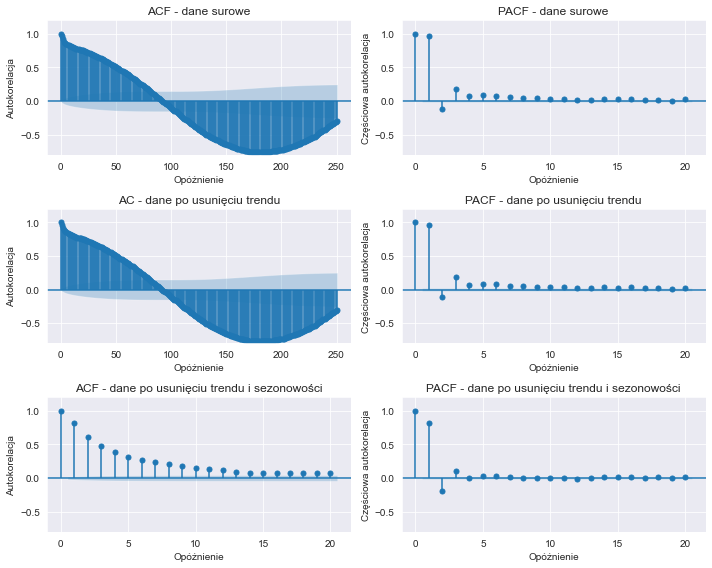

In [10]:
max_lag_acf = 250
max_lag_pacf = 20
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

plot_acf(avg_temp, lags=max_lag_acf, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(avg_temp, lags=max_lag_pacf, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(avg_temp_without_linear_trend, lags=max_lag_acf, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('AC - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(avg_temp_without_linear_trend, lags=max_lag_pacf, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.8, 1.2)

plot_acf(avg_temp_without_seasonal, lags=max_lag_pacf, ax=axes[2, 0])
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[2, 0].set_ylim(-0.8, 1.2)

plot_pacf(avg_temp_without_seasonal, lags=max_lag_pacf, ax=axes[2, 1])
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[2, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

Na wykresie poniżej przedstawiono periodogram dla szeregu po usunięciu trendu liniowego. Ekstremum obserwowane jest dla częstotliwości -0.0027, co odpowiada okresowi 365,25 dnia. Jest to zgodne z intuicją, która wskazuje na roczną okresowość danych

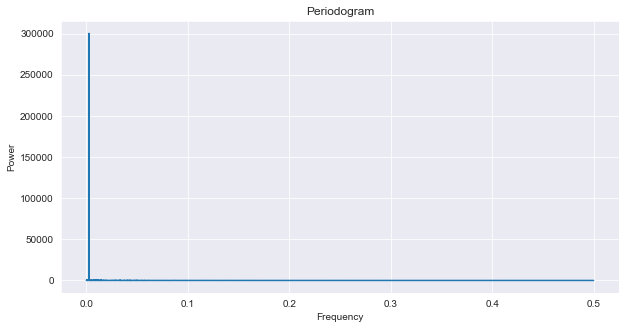

Top 5 Peaks (Frequency, Period):
Peak 1: -0.0027, -365.25
Peak 2: 0.0027, 365.25
Peak 3: 0.0004, 2556.75
Peak 4: -0.0004, -2556.75
Peak 5: -0.0023, -426.12
Peak 6: 0.0023, 426.12


In [11]:
# Periodogram

periodogram = np.abs(np.fft.fft(avg_temp_without_linear_trend))**2 / len(avg_temp_without_linear_trend)
frequencies = np.fft.fftfreq(len(avg_temp_without_linear_trend))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(avg_temp_without_linear_trend) // 2], periodogram[:len(avg_temp_without_linear_trend) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")

#### 2.3.2. Dekompozycja z użyciem funkcji seasonal_decompose
Na wykresach przedstawiono wyniki dekompozycji szeregu czasowego z wykorzystaniem funkcji seasonal_decompose. Wykorzystano model addytywny oraz okres 365 dni, zgodny z intuicją. 
Na wykresach przedstawiono surowe dane, składową trendu, składową sezonowości oraz dane po dekompozycji. Zwróćmy uwagę na wykres trendu - początkowy skok wartości wynika z różnic pomiędzy wartościami bezwzględnymi temperatur maksymalnych i minimalnych. Latem obserwowane są wyższe temperatury bezwzględne, niż te obserwowane zimą. W dalszej części wartość trendu jest rosnąca, jednak możemy zauważyć, że na przełomie ostatnich 30 lat temperatury wzorsły o około 3(STOPNIE)C. 

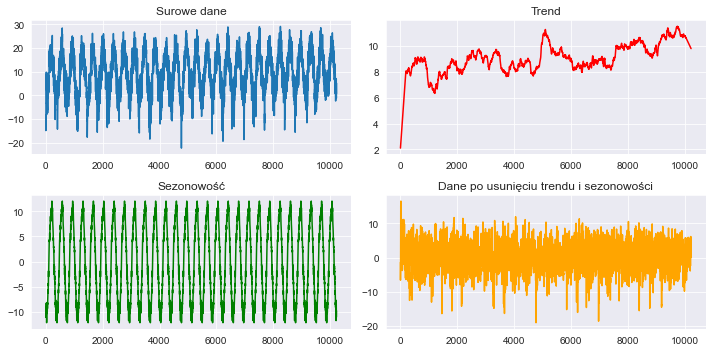

In [12]:
decomposition = seasonal_decompose(avg_temp, model='additive', period=365, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(avg_temp, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

#### 2.3.3. Dekompozycja z wykorzystaniem metody STL

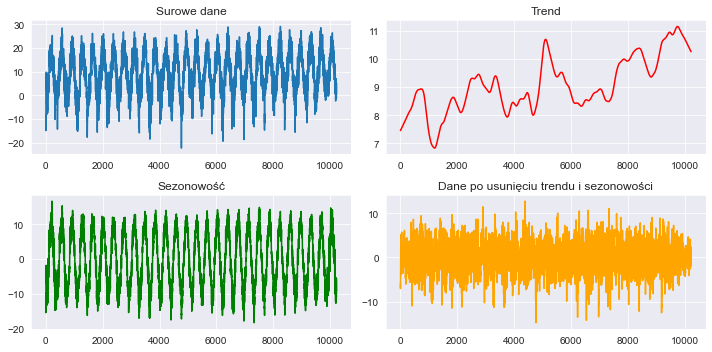

In [13]:
# https://otexts.com/fpp2/stl.html

stl_decomposition = STL(avg_temp, period=365).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(avg_temp, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

#### 2.3.4. Dekompozycja z wykorzystaniem metody Holta-Wintersa

C:\Users\agata\AppData\Local\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


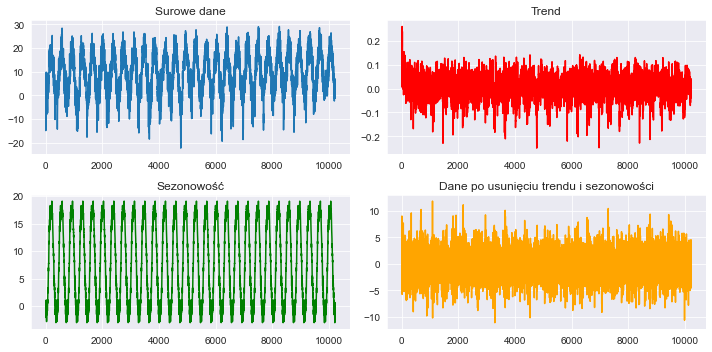

In [14]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(avg_temp, seasonal_periods=365, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(avg_temp, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

#### 2.3.5. Porównanie metod dekompozycji
Wykonano test ADF dla wszystkich z wykorzystanych metod. 
p-wartość dla każdej z metod nie przekroczyła wartości 0.05, co wskazuje na odrzucenie hipotezy o niestacjonarności. Każda z metod wyakzuje się dużą skutecznością redukując p-wartość testu względem p-wartości testu dla szeregu przed dekompozycją. 

In [15]:
average_temperature_after_decomposition1 = avg_temp_without_seasonal
average_temperature_after_decomposition2 = residual
average_temperature_after_decomposition3 = residual_stl
average_temperature_after_decomposition4 = residual_ets

# Sprawdzenie stacjonarności
adf_test1 = adfuller(average_temperature_after_decomposition1)
adf_test2 = adfuller(average_temperature_after_decomposition2)
adf_test3 = adfuller(average_temperature_after_decomposition3)
adf_test4 = adfuller(average_temperature_after_decomposition4)
print("ADF test p-value:", adf_test1[1])
print("ADF test p-value:", adf_test2[1])
print("ADF test p-value:", adf_test3[1])
print("ADF test p-value:", adf_test4[1])

ADF test p-value: 0.0
ADF test p-value: 0.0
ADF test p-value: 5.3819630506873414e-30
ADF test p-value: 0.0


## 3. Modelowanie danych przy pomocy ARMA
Wykorzystamy kryteria informacyjne do wyznaczenia rzędu modelu ARMA. Jako dane wejściwe wykorzystamy szereg po dekompozycji pierwszą oraz drugą metodą. 

Aby znaleźć rząd modelu konstruujemy obiekt ARIMA(p, 0, q) i badamy jego dopasowanie do szeregu po dekompozycji. Maksymalne wartości p i q zostały wyznaczone z obserwacji wykresów ACF i PACF szeregu. 

In [16]:
# Za pomocą kryteriow informacyjnych szukamy rzędu modelu

def inf_criteria(arma_process_trajectory, max_p=5, max_q=5):
    df = pd.DataFrame()
    
    ps = []
    qs = []
    BIC = []
    AIC = []
    HQIC = []

    
    # Iteracja po możliwych wartościach p i q
    for p in range(0, max_p):
        for q in range(0, max_q):
            
            # Dopasowanie modelu ARMA dla danego p i q
            model = ARIMA(arma_process_trajectory, order=(p, 0, q))
            model_fit = model.fit()
            
            # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
            ps.append(p)
            qs.append(q)
            AIC.append(model_fit.aic)
            BIC.append(model_fit.bic)
            HQIC.append(model_fit.hqic)
    
    df['p']    = ps
    df['q']    = qs
    df['AIC']  = AIC
    df['BIC']  = BIC
    df['HQIC'] = HQIC
    return df

In [17]:
df1 = inf_criteria(average_temperature_after_decomposition1)

C:\Users\agata\AppData\Local\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\agata\AppData\Local\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\agata\AppData\Local\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
df1.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,45421.239261,45464.63598,45435.912391


In [19]:
df1.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,45421.239261,45464.63598,45435.912391


In [20]:
df1.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,45421.239261,45464.63598,45435.912391


In [21]:
df2 = inf_criteria(average_temperature_after_decomposition2)

KeyboardInterrupt: 

In [ ]:
df2.sort_values(by='AIC').head(1)

In [ ]:
df2.sort_values(by='BIC').head(1)

In [ ]:
df2.sort_values(by='HQIC').head(1)

In [ ]:
# Automatyczny dobór modelu ARMA
model = pm.auto_arima(average_temperature_after_decomposition1, seasonal=False, trace=True, information_criterion='bic')
print(model.summary())

# Dopasowanie wybranego modelu
final_model = ARIMA(average_temperature_after_decomposition1, order=model.order)
results = final_model.fit()

# Podsumowanie wyników
# print(results.summary())

In [ ]:
model = pm.auto_arima(average_temperature_after_decomposition2, seasonal=False, trace=True, information_criterion='aic')
print(model.summary())

final_model = ARIMA(average_temperature_after_decomposition2, order=model.order)
results = final_model.fit()

# print(results.summary())

Oba szeregi wykazują najlepsze dopasowanie do modelu ARMA(2,2)
W dalszej części będziemy korzystali z tej informacji do wzyanczenia współczynników modelu. 

TO DO: opisać co jest wyznaczane, co oznaczją wyniki


In [23]:
p, q = 2, 2

model_first_method = ARIMA(average_temperature_after_decomposition1, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(average_temperature_after_decomposition1, order=(p, 0, q)).fit(method='innovations_mle')
model_third_method = ARIMA(average_temperature_after_decomposition1, order=(p, 0, q)).fit(method='hannan_rissanen')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())
print("\n")
print("Wyniki dla method='hannan_rissanen':\n")
print(model_third_method.summary())

Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10227
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -22704.620
Date:                Fri, 31 Jan 2025   AIC                          45421.239
Time:                        12:12:58   BIC                          45464.636
Sample:                             0   HQIC                         45435.912
                              - 10227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.131     -0.042      0.966      -0.262       0.251
ar.L1          1.4944      0.058     25.576      0.000       1.380       1.609
ar.L2         -0.53

In [ ]:
print(model_first_method.params[1:-1])
# print(model_second_method.params[1:-1])
# print(model_third_method.params[1:-1])

In [ ]:
plt.figure(figsize=(8,3))

plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
plt.plot(model_third_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')
plt.xticks(range(4), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])

plt.show()

## Ocena dopasowania modelu

In [ ]:
# Przedziały ufności dla PACF
phi_1, phi_2, theta_1, theta_2 = model_first_method.params[1:-1]

np.random.seed(42) 
ar_coef = np.array([1, -phi_1, -phi_2])
ma_coef = np.array([1, theta_1, theta_2])

n = 1000 
sigma2 = 4.93
num_simulations = 100
h = 20
confidence_level = 0.95

arma_process = ArmaProcess(ar_coef, ma_coef)

pacf_values = np.zeros((num_simulations, h+1))
for i in range(num_simulations):
    ts = arma_process.generate_sample(n, scale = np.sqrt(sigma2))
    pacf_est = pacf(ts, h) 
    pacf_values[i, :] = pacf_est
    
# Compute confidence intervals
lower_bounds = np.percentile(pacf_values, (1 - confidence_level) /2 * 100, axis=0)
upper_bounds = np.percentile(pacf_values, (1 + confidence_level) /2 * 100, axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.fill_between(range(1, h + 2), lower_bounds, upper_bounds, color='lightgray', label=f'{confidence_level * 100:.1f}% Confidence Interval')
plt.axhline(0, color='red', linestyle='--', label='PACF=0')

# Plot sample PACF of one realization for reference
sample_ts = arma_process.generate_sample(n, scale = np.sqrt(sigma2))
sample_pacf = pacf(sample_ts, h)
plt.plot(range(1, h + 2), sample_pacf, marker='o', label='PACF dla trajektorii modelu')
plt.plot(range(1, h + 2), pacf(avg_temp_without_seasonal, h), marker='o', label='PACF dla danych po dekompozycji')

plt.title(f'PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('PACF')
plt.legend()
plt.show()



In [ ]:
# Przedziały ufności dla PACF
phi_1, phi_2, theta_1, theta_2 = model_first_method.params[1:-1]

np.random.seed(42) 
ar_coef = np.array([1, -phi_1, -phi_2])
ma_coef = np.array([1, theta_1, theta_2])

n = 1000 
sigma2 = 4.93
num_simulations = 100
h = 40 // 2
confidence_level = 0.95

arma_process = ArmaProcess(ar_coef, ma_coef)

acf_values = np.zeros((num_simulations, h+1))

for i in range(num_simulations):
    ts = arma_process.generate_sample(n, scale = np.sqrt(sigma2))
    acf_est = acf(ts, nlags = h) 
    acf_values[i, :] = acf_est[0:h+1]
    
# Compute confidence intervals
lower_bounds = np.percentile(acf_values, (1 - confidence_level) /2 * 100, axis=0)
upper_bounds = np.percentile(acf_values, (1 + confidence_level) /2 * 100, axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.fill_between(range(1, h + 2), lower_bounds, upper_bounds, color='lightgray', label=f'{confidence_level * 100:.1f}% Confidence Interval')
plt.axhline(0, color='red', linestyle='--', label='ACF=0')

# Plot sample PACF of one realization for reference
sample_ts = arma_process.generate_sample(n, scale = np.sqrt(sigma2))
sample_acf = acf(sample_ts, h)[0:h+1]
plt.plot(range(1, h + 2), sample_acf, marker='o', label='ACF dla trajektorii modelu')
plt.plot(range(1, h + 2), acf(avg_temp_without_seasonal, nlags=h), marker='o', label='ACF dla danych po dekompozycji')

plt.title(f'ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('ACF')
plt.legend()
plt.show()


do rysunku wyzej: nie rozumiem czemu acf robi się dla 2*h?
    co z szumem?

## Weryfikacja założeń dotyczących szumu

In [ ]:
# Wyznaczanie residuów na podstawie dopasowanego modelu
resid_1 = model_first_method.resid
resid_2 = model_second_method.resid

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(resid_1[:1000])
plt.title('Residua dla modelu (parametry obliczone metodą 1, 1000 pierwszych)')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.subplot(2, 1, 2)
plt.plot(resid_2[:1000])
plt.title('Residua dla modelu (parametry obliczone metodą 2, 1000 pierwszych)')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.show()

In [ ]:
# Wbudowana funkcja do podstowej diagnostyki modelu
model_first_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

model_second_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()